In [ ]:
# %%

# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), "..")))

import importlib
import preprocessing.pipeline
importlib.reload(preprocessing.pipeline)
from preprocessing.pipeline import get_preprocessor

# === Additional imports for cross-validation ===
from sklearn.model_selection import KFold, cross_val_score

In [ ]:
# %%

# === Import data ===
train = pd.read_csv("../data/train.csv")
X_test = pd.read_csv("../data/test.csv")

X_train = train.drop("SalePrice", axis=1)
y_train = train["SalePrice"]

In [ ]:
# %%

# === Build preprocessing + modeling pipeline ===
model_pipeline = Pipeline([
  ("preprocessor", get_preprocessor()),
  ("model", TransformedTargetRegressor(
		regressor=RandomForestRegressor(n_estimators=100, random_state=42),
		func=np.log1p,
		inverse_func=np.expm1
	))
])

In [ ]:
# %%

# === Hyperparameter Tuning with GridSearchCV ===
param_grid = {
  "model__regressor__n_estimators": [20, 50, 100, 200], # 50
  "model__regressor__max_depth": [10, 15, 20, None], # 15
  "model__regressor__min_samples_leaf": [2, 4, 6, 8], # 2
  "model__regressor__min_samples_split": [2, 4, 6, 8], # 2
  "model__regressor__max_features": [0.5, "sqrt", "log2"] # 0.5
}

cv = KFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(
  model_pipeline,
  param_grid,
  cv=cv,
  scoring="neg_root_mean_squared_error",
  n_jobs=-1,
  verbose=1
)


grid_search.fit(X_train, y_train)

# Compute RMSE on cross-validated predictions from the training set
from sklearn.model_selection import cross_val_predict

cv_train_preds = cross_val_predict(grid_search, X_train, y_train, cv=cv)
cv_train_rmse = np.sqrt(mean_squared_error(y_train, cv_train_preds))
print(f"Train RMSE (from CV predictions): {cv_train_rmse:.2f}")
print(f"Best CV RMSE: {-grid_search.best_score_:.2f}")
print(f"Best parameters: {grid_search.best_params_}")

# Use the best estimator from the search for further evaluation
model_pipeline = grid_search.best_estimator_

Fitting 10 folds for each of 768 candidates, totalling 7680 fits
Fitting 10 folds for each of 768 candidates, totalling 7680 fits
Fitting 10 folds for each of 768 candidates, totalling 7680 fits
Fitting 10 folds for each of 768 candidates, totalling 7680 fits
Fitting 10 folds for each of 768 candidates, totalling 7680 fits
Fitting 10 folds for each of 768 candidates, totalling 7680 fits
Fitting 10 folds for each of 768 candidates, totalling 7680 fits
Fitting 10 folds for each of 768 candidates, totalling 7680 fits
Fitting 10 folds for each of 768 candidates, totalling 7680 fits
Fitting 10 folds for each of 768 candidates, totalling 7680 fits
Fitting 10 folds for each of 768 candidates, totalling 7680 fits
Train RMSE (from CV predictions): 28992.56
Best CV RMSE: 28656.37
Best parameters: {'model__regressor__max_depth': 20, 'model__regressor__max_features': 0.5, 'model__regressor__min_samples_leaf': 2, 'model__regressor__min_samples_split': 2, 'model__regressor__n_estimators': 100}


In [ ]:
# %%

# === Fit on full training data ===
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessing',
                                  Pipeline(steps=[('drop_id',
                                                   ColumnDropper(columns_to_drop=['Id'])),
                                                  ('cat_na_fill',
                                                   CategoricalNaFiller(excluded_cols=['GarageYrBlt'])),
                                                  ('num_na_fill',
                                                   NumericalNaFiller(excluded_cols=['LotFrontage'])),
                                                  ('garage_bin',
                                                   GarageYrBltBinner()),
                                                  ('skewed_transform',
                                                   SkewedFeatureTransformer())])),
                                 ('transformer', OneHotEncoderScaler()),
                                 ('lotfrontage_fill', LotFrontageFiller())])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=RandomForestRegressor(max_depth=20,
                                                                            max_features=0.5,
                                                                            min_samples_leaf=2,
                                                                            random_state=42)))])

In [ ]:
# %%

# === Evaluate on training data ===
y_train_pred = model_pipeline.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Train R² Score: {train_r2:.4f}")

Train RMSE: 13405.13
Train R² Score: 0.9715



=== Feature Importances ===


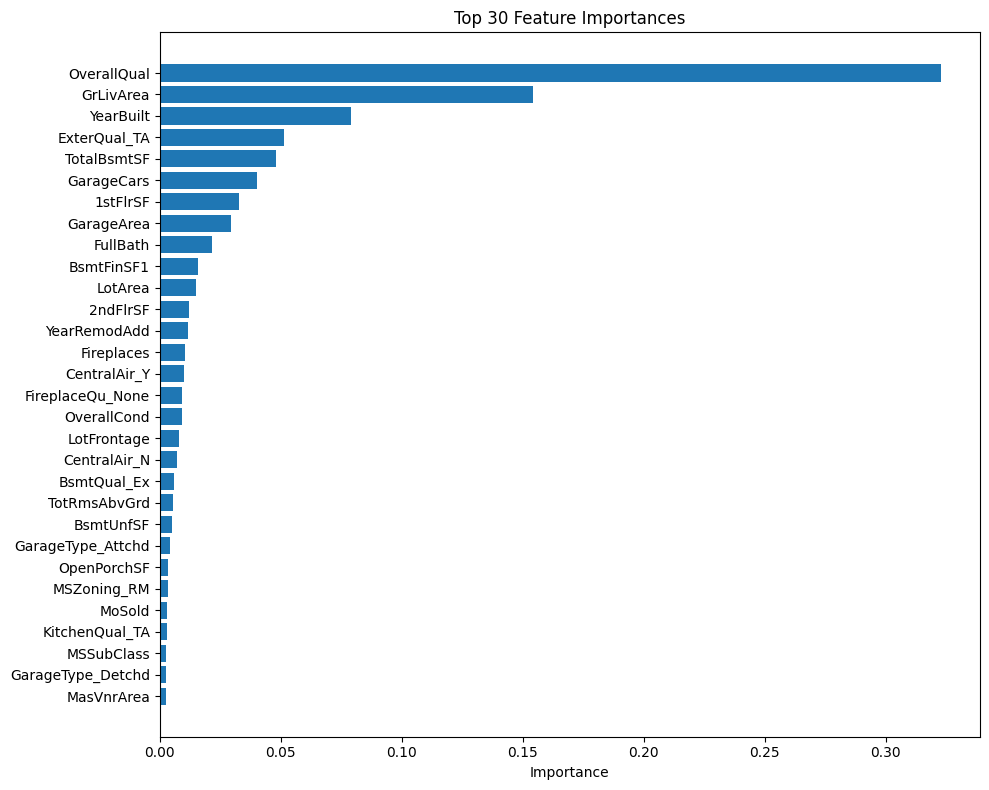

In [ ]:
# %%

# === Feature Importances ===
print("\n=== Feature Importances ===")
model = model_pipeline.named_steps["model"].regressor_
feature_names = model_pipeline.named_steps["preprocessor"].named_steps["transformer"].get_feature_names_out()
importances = model.feature_importances_

# Create a DataFrame for plotting
feat_imp_df = pd.DataFrame({
  "Feature": feature_names,
  "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df["Feature"][:30][::-1], feat_imp_df["Importance"][:30][::-1])
plt.xlabel("Importance")
plt.title("Top 30 Feature Importances")
plt.tight_layout()
plt.show()

In [ ]:
# %%

# === Predict on test data ===
y_test_pred = model_pipeline.predict(X_test)

In [ ]:
# %%

# === Wrap in DataFrame ===
submission = pd.DataFrame({
  "Id": X_test["Id"],  # assuming 'Id' is in test data
  "SalePrice": y_test_pred
})

submission.head()

,Id,SalePrice
0,1461,125208.055779
1,1462,151883.705598
2,1463,175446.672728
3,1464,184487.264790
4,1465,199839.878960


In [ ]:
# %%

# === Save in submission file ===
submission.to_csv("../data/submission.csv", index=False)